# Training Classification Model

In this notebook, we will train a very simple classification model for labeling Cherenkov radiation shower images. The images will be classified as those caused by primary gammas (signal) and those initiated by cosmic rays in the upper atmosphere (background). You can find more information about the problem domain <a href="https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope" target="_blank" rel="noopener">here</a>.

We will train the model in this notebook using <a href="https://scikit-learn.org/stable/" target="_blank" rel="noopener">`scikit-learn`</a>, on the training data we are going to export from the database.

To execute queries and load data from the Exasol database we will be using the <a href="https://github.com/exasol/pyexasol" target="_blank" rel="noopener">`pyexasol`</a> module.

## Prerequisites

Prior to using this notebook the following steps need to be completed:
1. [Configure the sandbox](../sandbox_config.ipynb).
2. [Load the MAGIC Gamma Telescope data](../data/data_telescope.ipynb).

## Setup

### Access configuration

In [9]:
%run ../access_store_ui.ipynb
display(get_access_store_ui('../'))

## Load data

First, we will export data into a pandas DataFrame.

In [3]:
import pyexasol
from stopwatch import Stopwatch

stopwatch = Stopwatch()

dsn = f'{sb_config.EXTERNAL_HOST_NAME}:{sb_config.HOST_PORT}'
with pyexasol.connect(dsn=dsn, user=sb_config.USER, password=sb_config.PASSWORD, compression=True) as conn:
    df = conn.export_to_pandas(query_or_table=(sb_config.SCHEMA, 'TELESCOPE_TRAIN'))

print(f"Loading the data took: {stopwatch}")

Loading the data took: 1.49s


## Train model

The data has no missing values. In order to keep things simple we will be using a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier" target="_blank" rel="noopener">`Decision Tree Classifier`</a> algorithm which requires little in terms of pre-processing for this dataset.

In [4]:
from sklearn import tree
from sklearn.model_selection import train_test_split

# Split the dataset into train and validation sets. Use all available features columns.
X, y = df.drop(columns='CLASS'), df['CLASS']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

stopwatch = Stopwatch()

# Create and train the model.
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

print(f"Training took: {stopwatch}")

Training took: 126.99ms


## Evaluate model

Let's evaluate the model using the validation set.
The results may not look particularly impressive but it's OK. We are aiming for simplicity and clarity, not the best prediction performance.

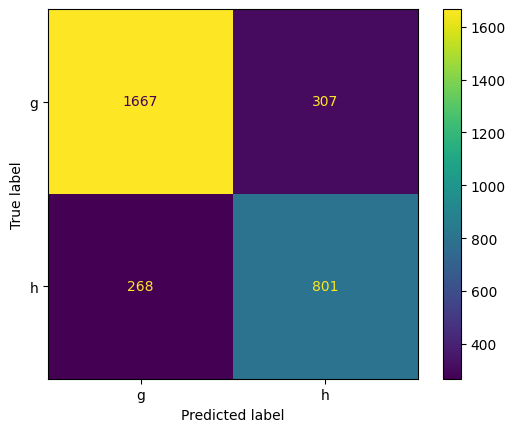

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make the predictions on the validation set.
y_pred = model.predict(X_valid)

# Build and display the confusion matrix.
cm = confusion_matrix(y_valid, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

## Upload model into BucketFS

Now, let's upload the model into the BucketFS so that it can be used for making classification in SQL queries. To communicate with BucketFS we will be using the <a href="https://exasol.github.io/bucketfs-python/" target="_blank" rel="noopener">`bucketfs-python`</a> module. 

In [11]:
import pickle
from exasol.bucketfs import Service

MODEL_FILE = 'telescope_tree_model.pkl'

# Setup the connection parameters.
buckfs_url_prefix = 'https' if sb_config.BUCKETFS_USE_HTTPS == 'True' else 'http'
buckfs_url = f'{buckfs_url_prefix}://{sb_config.EXTERNAL_HOST_NAME}:{sb_config.BUCKETFS_PORT}'
buckfs_credentials = {sb_config.BUCKETFS_BUCKET: {'username': sb_config.BUCKETFS_USER, 'password': sb_config.BUCKETFS_PASSWORD}}

stopwatch = Stopwatch()

# Connect to the BucketFS service and navigate to the bucket of choice.
bucketfs = Service(buckfs_url, buckfs_credentials)
bucket = bucketfs[sb_config.BUCKETFS_BUCKET]

# Serialize the model into a byte-array and upload it to the BucketFS, 
# where it will be saved in the file with the specified name.
bucket.upload(MODEL_FILE, pickle.dumps(model))

print(f"Uploading the model took: {stopwatch}")

Uploading the model took: 699.20ms


Now we are ready to use this model in our SQL queries. This will be demonstrated in the [following notebook](sklearn_predict_telescope.ipynb)

In [8]:
buckfs_url

'http://192.168.124.93:666'